# Exploratory Data Analysis - NBA Playoff Prediction

This notebook generates comprehensive exploratory data analysis for predicting NBA playoff teams, including:
1. Feature distributions and relationships with target variable
2. Correlation matrix analysis
3. PCA dimensionality reduction and variance analysis
4. K-means clustering to uncover data structure

## 1. Load and Explore Data

Load the scaled training data, labels, and feature names. Display basic statistics about the dataset.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy import stats
import json
import warnings
warnings.filterwarnings('ignore')

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

# Paths
DATA_PATH = Path("./data/processed")
OUTPUT_DIR = Path("./results/eda")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("="*80)
print("EXPLORATORY DATA ANALYSIS - NBA PLAYOFF PREDICTION")
print("="*80)

X_train = np.load(DATA_PATH / "X_train_scaled.npy")
y_train = np.load(DATA_PATH / "y_train.npy")

with open(DATA_PATH / "feature_names.json", "r") as f:
    feature_names = json.load(f)

excluded_features = {
    "pointsInThePaint_mean",
    "pointsFastBreak_mean", 
    "pointsFromTurnovers_mean",
    "benchPoints_mean"
}

feature_indices = [i for i, f in enumerate(feature_names) if f not in excluded_features]
features_removed = [f for f in feature_names if f in excluded_features]
X_train = X_train[:, feature_indices]
feature_names = [f for f in feature_names if f not in excluded_features]

print(f"Loaded: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Excluded features: {features_removed}")
print(f"Target distribution: {np.sum(y_train)} playoff teams, {len(y_train) - np.sum(y_train)} non-playoff teams")
print(f"Class balance: {np.sum(y_train)/len(y_train)*100:.1f}% playoff teams")

# Create DataFrame for easier manipulation
df = pd.DataFrame(X_train, columns=feature_names)
df['made_playoffs'] = y_train

EXPLORATORY DATA ANALYSIS - NBA PLAYOFF PREDICTION
Loaded: 446 samples, 27 features
Excluded features: []
Target distribution: 240 playoff teams, 206 non-playoff teams
Class balance: 53.8% playoff teams


## 2. Visualize Feature Distributions

Create overlaid histograms showing the distribution of all features separated by playoff status.

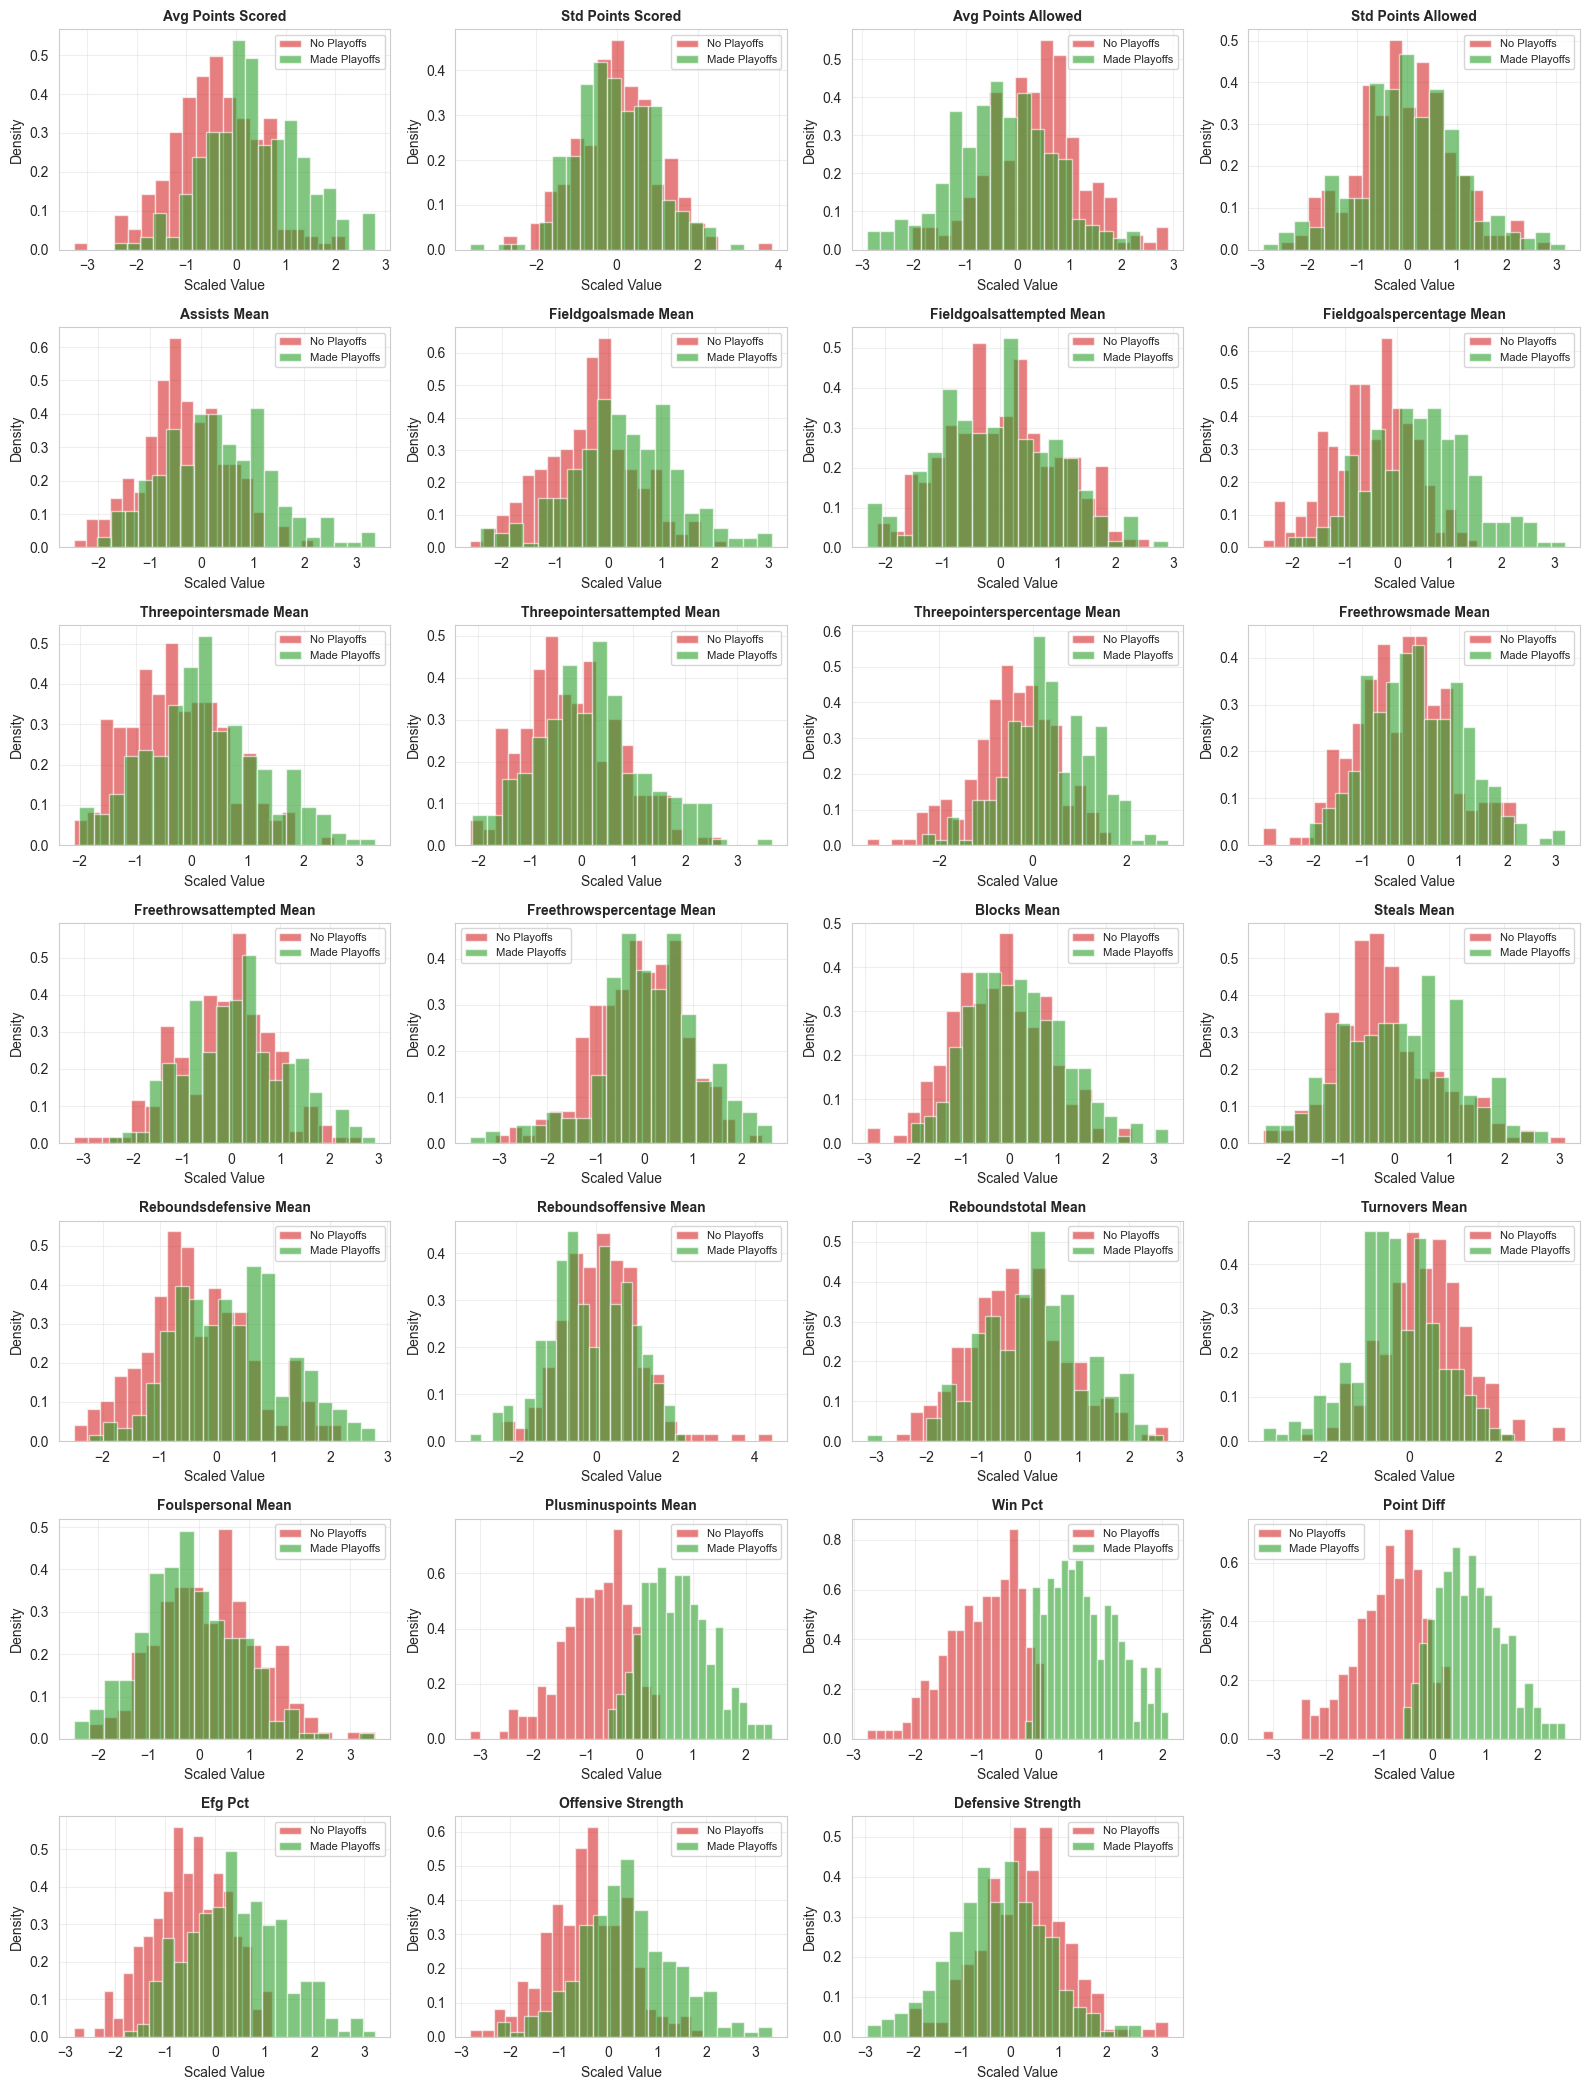

Saved: 01_feature_distributions.png


In [15]:
n_features = len(feature_names)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for idx, feature in enumerate(feature_names):
    ax = axes[idx]
    
    playoff_data = df[df['made_playoffs'] == 1][feature]
    no_playoff_data = df[df['made_playoffs'] == 0][feature]
    
    ax.hist(no_playoff_data, bins=20, alpha=0.6, label='No Playoffs', color='#d62728', density=True)
    ax.hist(playoff_data, bins=20, alpha=0.6, label='Made Playoffs', color='#2ca02c', density=True)
    
    ax.set_title(feature.replace('_', ' ').title(), fontsize=10, fontweight='bold')
    ax.set_xlabel('Scaled Value')
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "01_feature_distributions.png", dpi=300, bbox_inches='tight')
plt.show()
print("Saved: 01_feature_distributions.png")

## 3. Analyze Feature-Target Relationships

Generate box plots for the top 12 features by variance, comparing playoff and non-playoff teams.

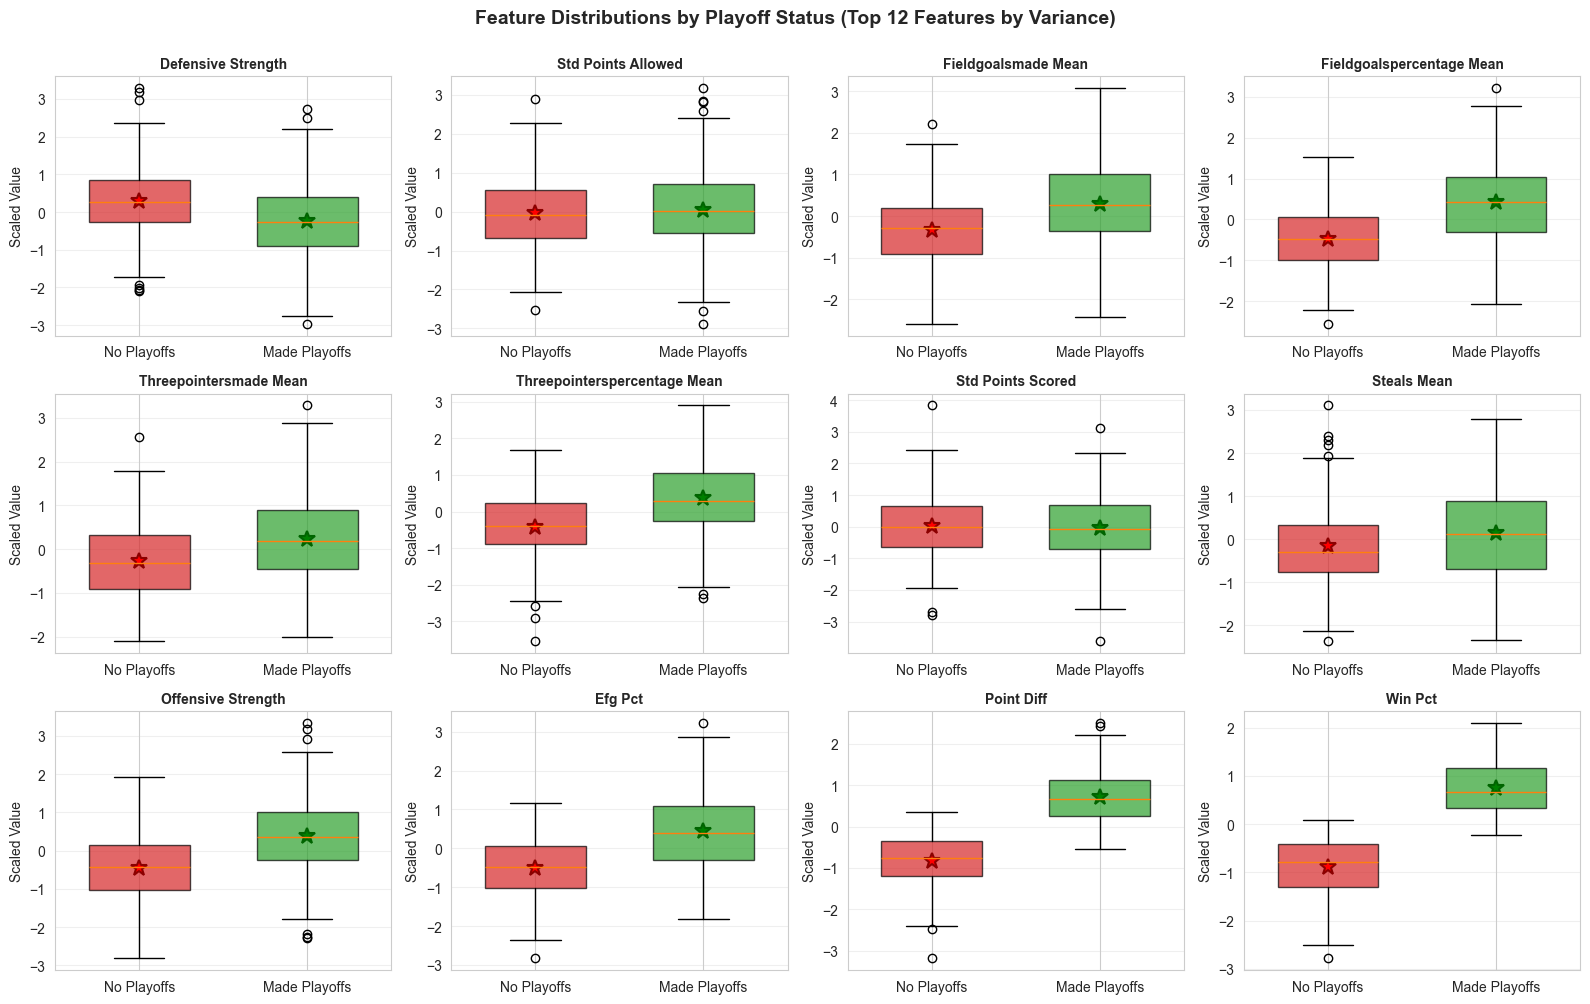

Saved: 02_feature_target_relationships.png


In [16]:
feature_variances = df[feature_names].var().sort_values(ascending=False)
top_features = feature_variances.head(12).index.tolist()

fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    
    playoff_data = df[df['made_playoffs'] == 1][feature]
    no_playoff_data = df[df['made_playoffs'] == 0][feature]
    
    bp = ax.boxplot([no_playoff_data, playoff_data], 
                     labels=['No Playoffs', 'Made Playoffs'],
                     patch_artist=True,
                     widths=0.6)
    
    bp['boxes'][0].set_facecolor('#d62728')
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_facecolor('#2ca02c')
    bp['boxes'][1].set_alpha(0.7)
    
    ax.set_title(feature.replace('_', ' ').title(), fontsize=10, fontweight='bold')
    ax.set_ylabel('Scaled Value')
    ax.grid(alpha=0.3, axis='y')
    
    ax.plot(1, no_playoff_data.mean(), 'r*', markersize=12, markeredgecolor='darkred', markeredgewidth=1.5)
    ax.plot(2, playoff_data.mean(), 'g*', markersize=12, markeredgecolor='darkgreen', markeredgewidth=1.5)

plt.suptitle('Feature Distributions by Playoff Status (Top 12 Features by Variance)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "02_feature_target_relationships.png", dpi=300, bbox_inches='tight')
plt.show()
print("Saved: 02_feature_target_relationships.png")

## 4. Compute and Visualize Correlation Matrix

Calculate correlation matrix and identify high correlation pairs (|r| > 0.7).

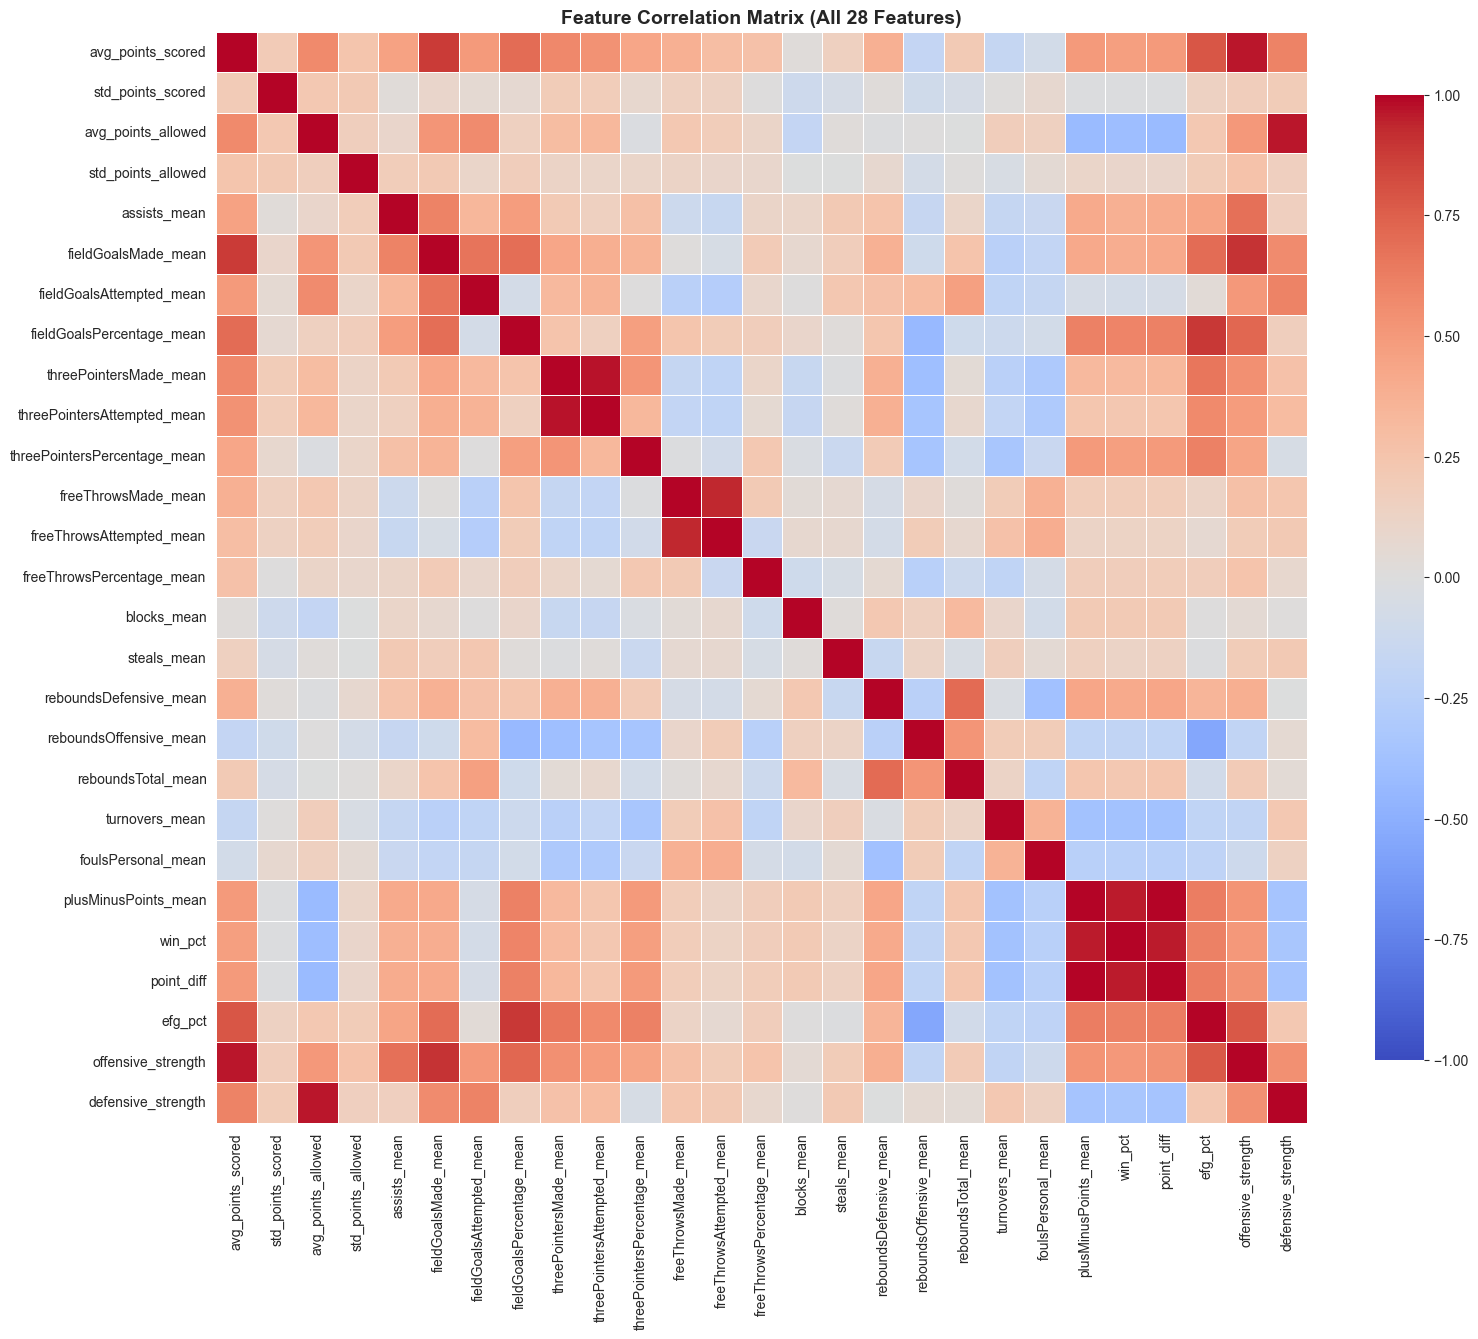

                Feature 1                   Feature 2  Correlation
     plusMinusPoints_mean                  point_diff     0.998476
   threePointersMade_mean threePointersAttempted_mean     0.975907
       avg_points_allowed          defensive_strength     0.962659
        avg_points_scored          offensive_strength     0.961772
                  win_pct                  point_diff     0.955093
     plusMinusPoints_mean                     win_pct     0.954643
      freeThrowsMade_mean    freeThrowsAttempted_mean     0.936177
      fieldGoalsMade_mean          offensive_strength     0.906113
fieldGoalsPercentage_mean                     efg_pct     0.890138
        avg_points_scored         fieldGoalsMade_mean     0.877977
        avg_points_scored                     efg_pct     0.784060
                  efg_pct          offensive_strength     0.780969
fieldGoalsPercentage_mean          offensive_strength     0.721253
   reboundsDefensive_mean          reboundsTotal_mean     0.70

In [17]:
# Compute correlation matrix (exclude target for feature correlations)
corr_matrix = df[feature_names].corr()

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Feature Correlation Matrix (All 28 Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "03_correlation_matrix_full.png", dpi=300, bbox_inches='tight')
plt.show()

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
    print(high_corr_df.to_string(index=False))
    high_corr_df.to_csv(OUTPUT_DIR / "high_correlation_pairs.csv", index=False)
else:
    print("No feature pairs with |correlation| > 0.7 found")

## 5. Apply PCA Dimensionality Reduction

Zero-center the data and fit PCA to compute explained variance ratios and principal components.

In [18]:
# Step 1: Flatten data to 1D vectors (already done - each sample is a 1D vector of features)
# Step 2: Zero-center the data (subtract mean)
X_centered = X_train - np.mean(X_train, axis=0)

pca = PCA()
X_pca = pca.fit_transform(X_centered)

cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1

print(f"PCA Analysis:")
print(f"  - Total features: {X_train.shape[1]}")
print(f"  - Components for 90% variance: {n_components_90}")
print(f"  - Components for 95% variance: {n_components_95}")
print(f"  - First component explains: {pca.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"  - First 2 components explain: {np.sum(pca.explained_variance_ratio_[:2])*100:.2f}% of variance")
print(f"  - First 3 components explain: {np.sum(pca.explained_variance_ratio_[:3])*100:.2f}% of variance")

PCA Analysis:
  - Total features: 27
  - Components for 90% variance: 11
  - Components for 95% variance: 13
  - First component explains: 29.56% of variance
  - First 2 components explain: 44.56% of variance
  - First 3 components explain: 55.65% of variance


## 6. Visualize PCA Components and Variance

Generate multiple visualizations of PCA results including component distributions, scree plots, and loadings.

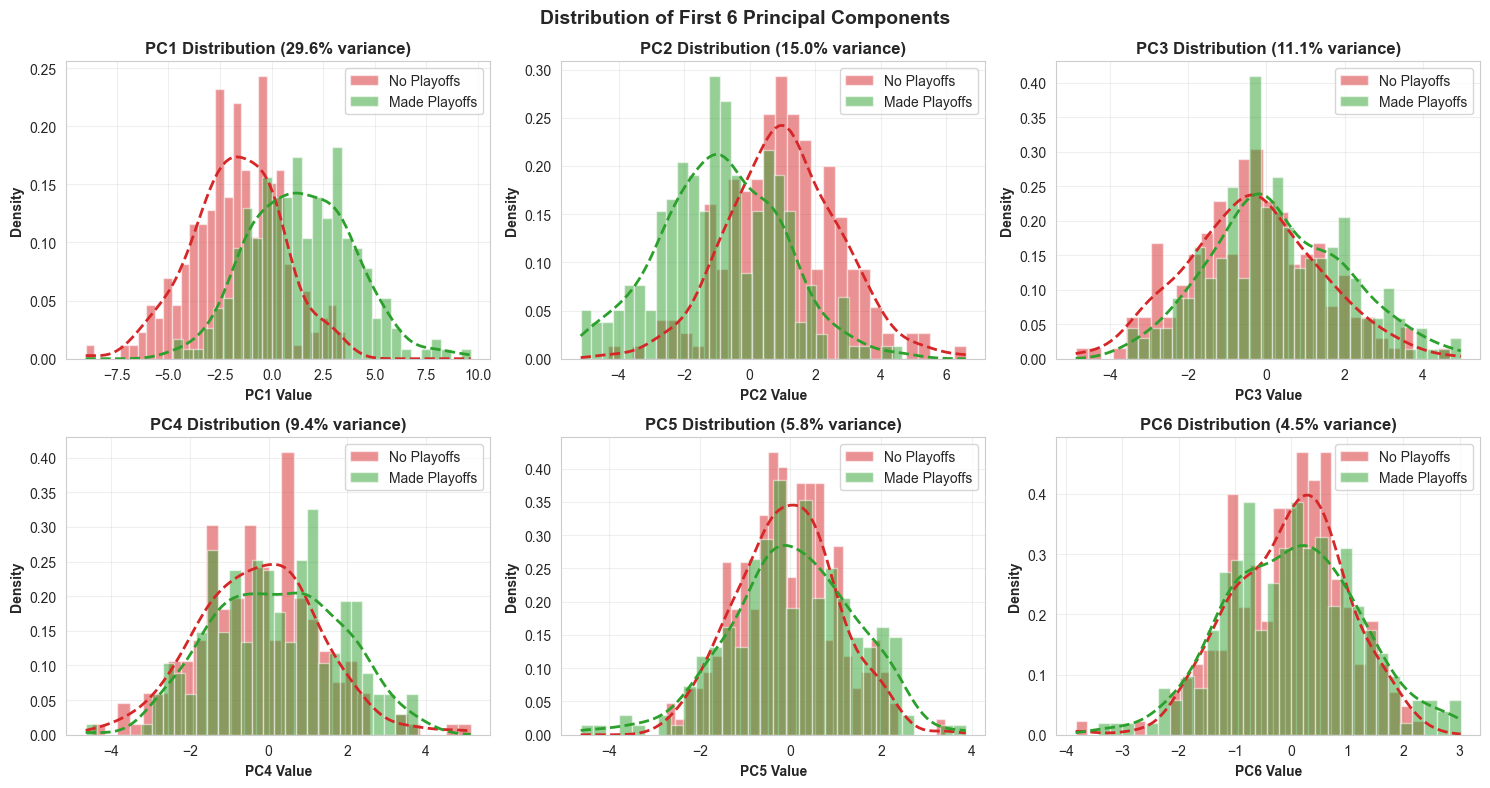

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(6):
    ax = axes[i]
    
    playoff_pc = X_pca[y_train == 1, i]
    no_playoff_pc = X_pca[y_train == 0, i]
    
    ax.hist(no_playoff_pc, bins=30, alpha=0.5, label='No Playoffs', color='#d62728', density=True)
    ax.hist(playoff_pc, bins=30, alpha=0.5, label='Made Playoffs', color='#2ca02c', density=True)
    
    kde_no = stats.gaussian_kde(no_playoff_pc)
    kde_yes = stats.gaussian_kde(playoff_pc)
    x_range = np.linspace(X_pca[:, i].min(), X_pca[:, i].max(), 100)
    ax.plot(x_range, kde_no(x_range), color='#d62728', linewidth=2, linestyle='--')
    ax.plot(x_range, kde_yes(x_range), color='#2ca02c', linewidth=2, linestyle='--')
    
    ax.set_xlabel(f'PC{i+1} Value', fontweight='bold')
    ax.set_ylabel('Density', fontweight='bold')
    ax.set_title(f'PC{i+1} Distribution ({pca.explained_variance_ratio_[i]*100:.1f}% variance)', 
                 fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Distribution of First 6 Principal Components', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "04a_pca_component_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

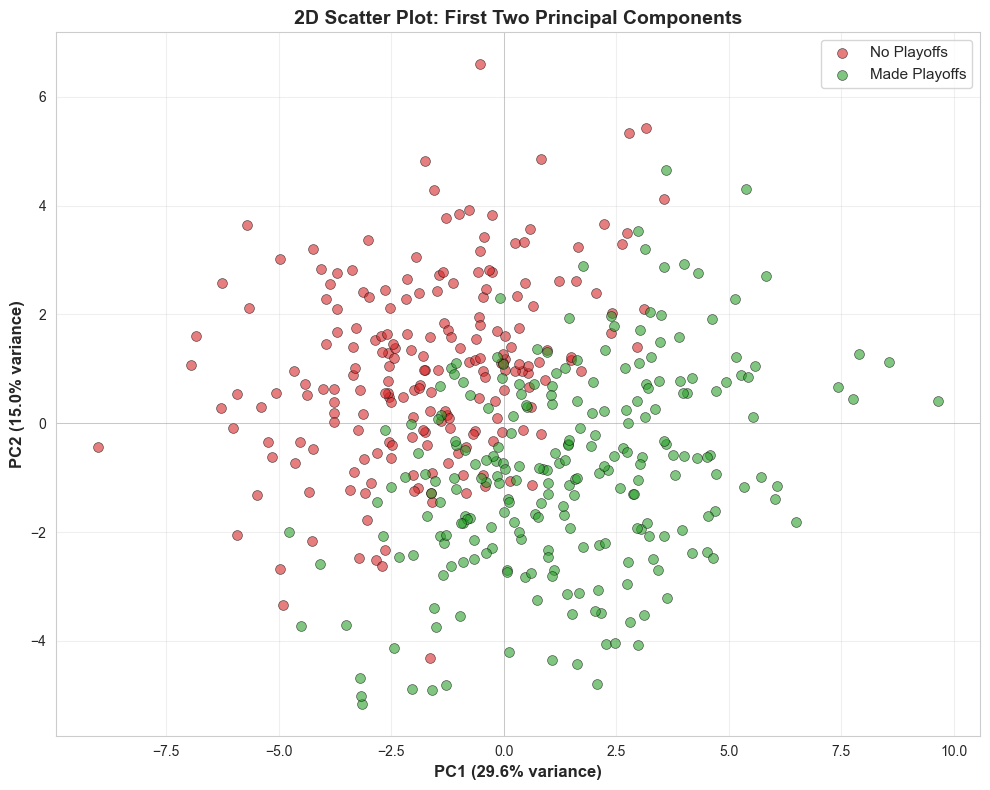

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

no_playoff_mask = y_train == 0
playoff_mask = y_train == 1

ax.scatter(X_pca[no_playoff_mask, 0], X_pca[no_playoff_mask, 1], 
           c='#d62728', label='No Playoffs', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax.scatter(X_pca[playoff_mask, 0], X_pca[playoff_mask, 1], 
           c='#2ca02c', label='Made Playoffs', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontweight='bold', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontweight='bold', fontsize=12)
ax.set_title('2D Scatter Plot: First Two Principal Components', fontweight='bold', fontsize=14)
ax.legend(loc='best', fontsize=11)
ax.grid(alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "04b_pca_scatter_2d.png", dpi=300, bbox_inches='tight')
plt.show()

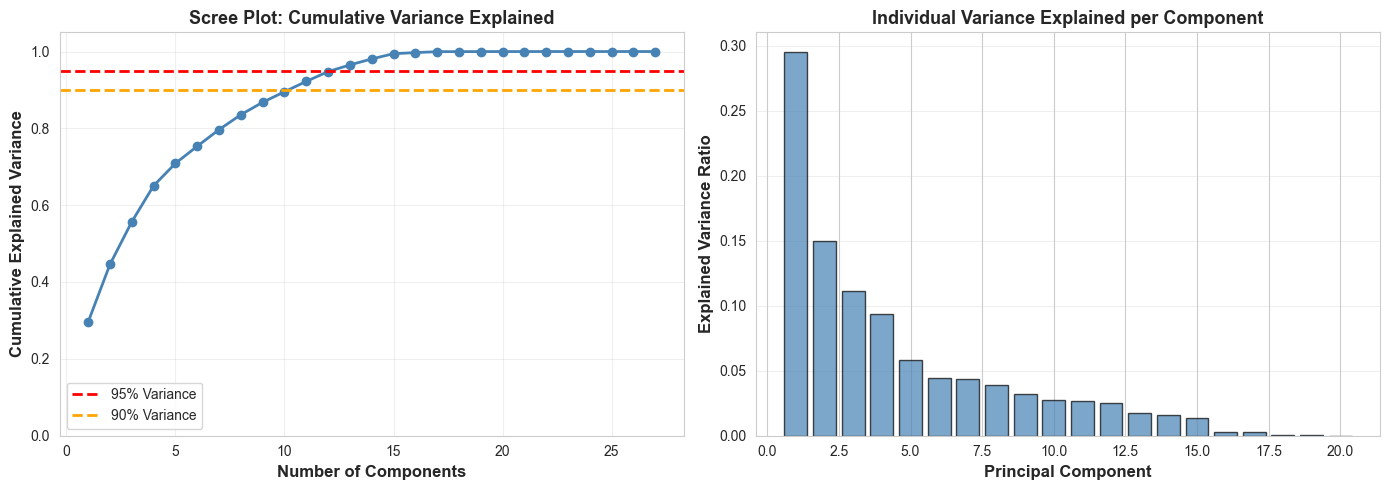

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
ax.plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 'o-', linewidth=2, markersize=6, color='steelblue')
ax.axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% Variance')
ax.axhline(y=0.90, color='orange', linestyle='--', linewidth=2, label='90% Variance')
ax.set_xlabel('Number of Components', fontweight='bold', fontsize=12)
ax.set_ylabel('Cumulative Explained Variance', fontweight='bold', fontsize=12)
ax.set_title('Scree Plot: Cumulative Variance Explained', fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_ylim([0, 1.05])

ax = axes[1]
n_components_to_show = min(len(pca.explained_variance_ratio_), 20)
ax.bar(range(1, n_components_to_show + 1), 
       pca.explained_variance_ratio_[:n_components_to_show], alpha=0.7, color='steelblue', edgecolor='black')
ax.set_xlabel('Principal Component', fontweight='bold', fontsize=12)
ax.set_ylabel('Explained Variance Ratio', fontweight='bold', fontsize=12)
ax.set_title('Individual Variance Explained per Component', fontweight='bold', fontsize=13)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "04c_pca_variance_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

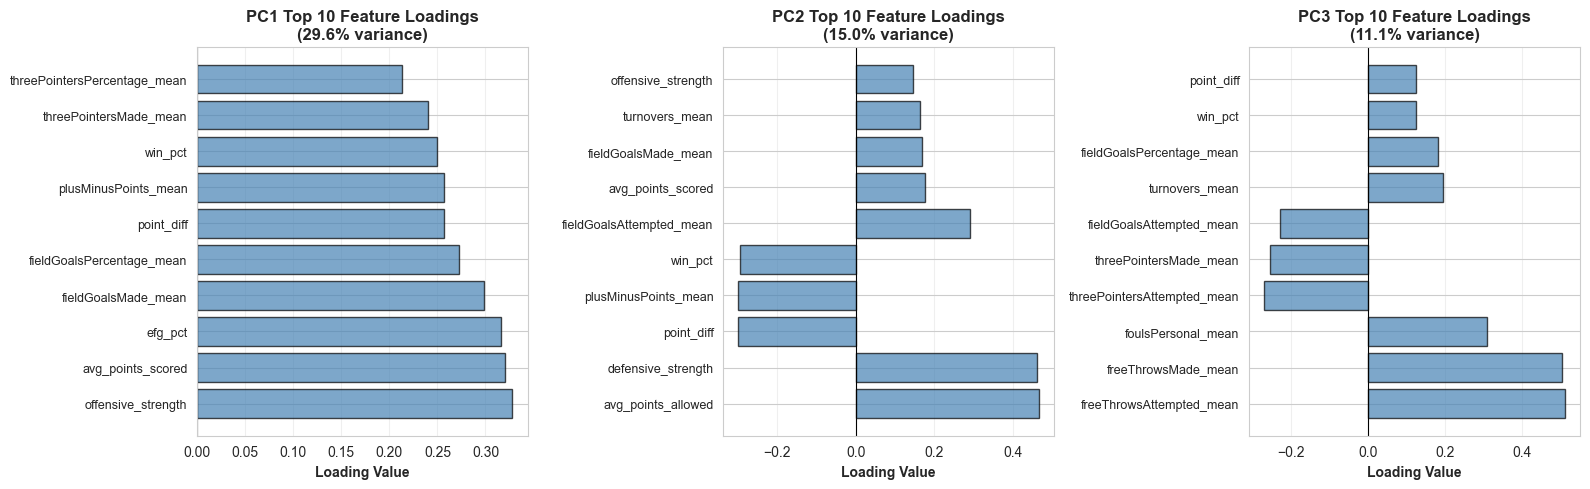

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i in range(3):
    ax = axes[i]
    loadings = pca.components_[i]
    sorted_idx = np.argsort(np.abs(loadings))[::-1][:10]
    
    ax.barh(range(10), loadings[sorted_idx], color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_yticks(range(10))
    ax.set_yticklabels([feature_names[idx] for idx in sorted_idx], fontsize=9)
    ax.set_xlabel('Loading Value', fontweight='bold')
    ax.set_title(f'PC{i+1} Top 10 Feature Loadings\n({pca.explained_variance_ratio_[i]*100:.1f}% variance)', 
                 fontweight='bold')
    ax.grid(alpha=0.3, axis='x')
    ax.axvline(x=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "04d_pca_component_loadings.png", dpi=300, bbox_inches='tight')
plt.show()

## 7. Perform K-Means Clustering

Apply K-means clustering to PCA-transformed data and find optimal number of clusters using elbow method and silhouette scores.

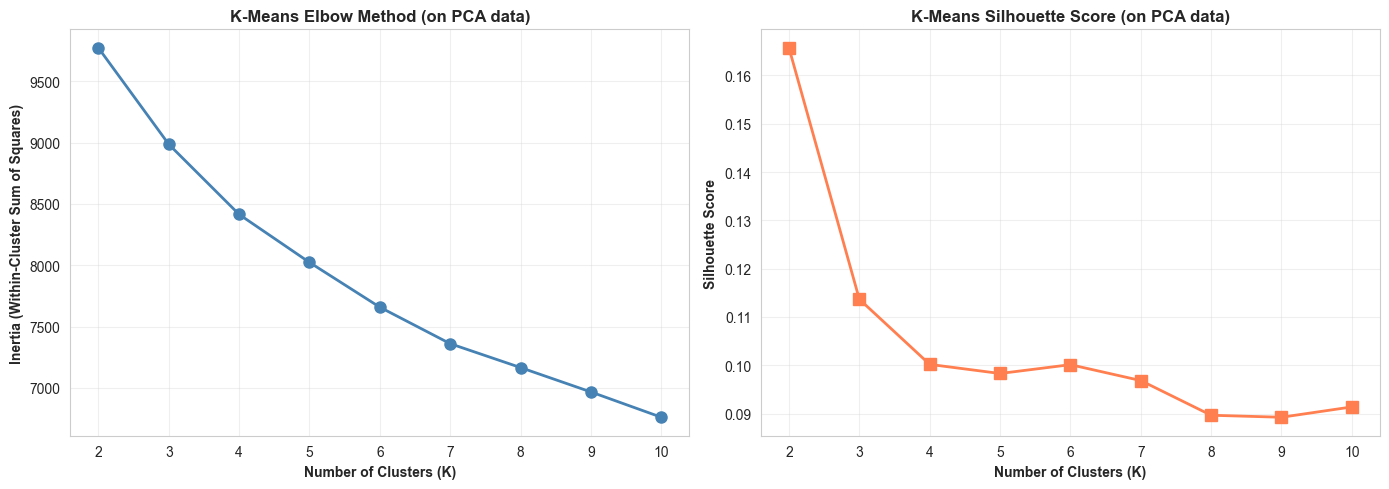

  - Optimal K by silhouette score: 2 (score: 0.166)


In [23]:
# Elbow method to find optimal K on PCA data
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(K_range, inertias, 'o-', linewidth=2, markersize=8, color='steelblue')
ax.set_xlabel('Number of Clusters (K)', fontweight='bold')
ax.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontweight='bold')
ax.set_title('K-Means Elbow Method (on PCA data)', fontweight='bold')
ax.grid(alpha=0.3)

ax = axes[1]
ax.plot(K_range, silhouette_scores, 's-', linewidth=2, markersize=8, color='coral')
ax.set_xlabel('Number of Clusters (K)', fontweight='bold')
ax.set_ylabel('Silhouette Score', fontweight='bold')
ax.set_title('K-Means Silhouette Score (on PCA data)', fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "05_kmeans_elbow_silhouette.png", dpi=300, bbox_inches='tight')
plt.show()

best_k = K_range[np.argmax(silhouette_scores)]
print(f"  - Optimal K by silhouette score: {best_k} (score: {max(silhouette_scores):.3f})")

kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_best.fit_predict(X_pca)

## 8. Analyze Cluster Alignment with Playoff Labels

Visualize and analyze how well the discovered clusters align with actual playoff outcomes.

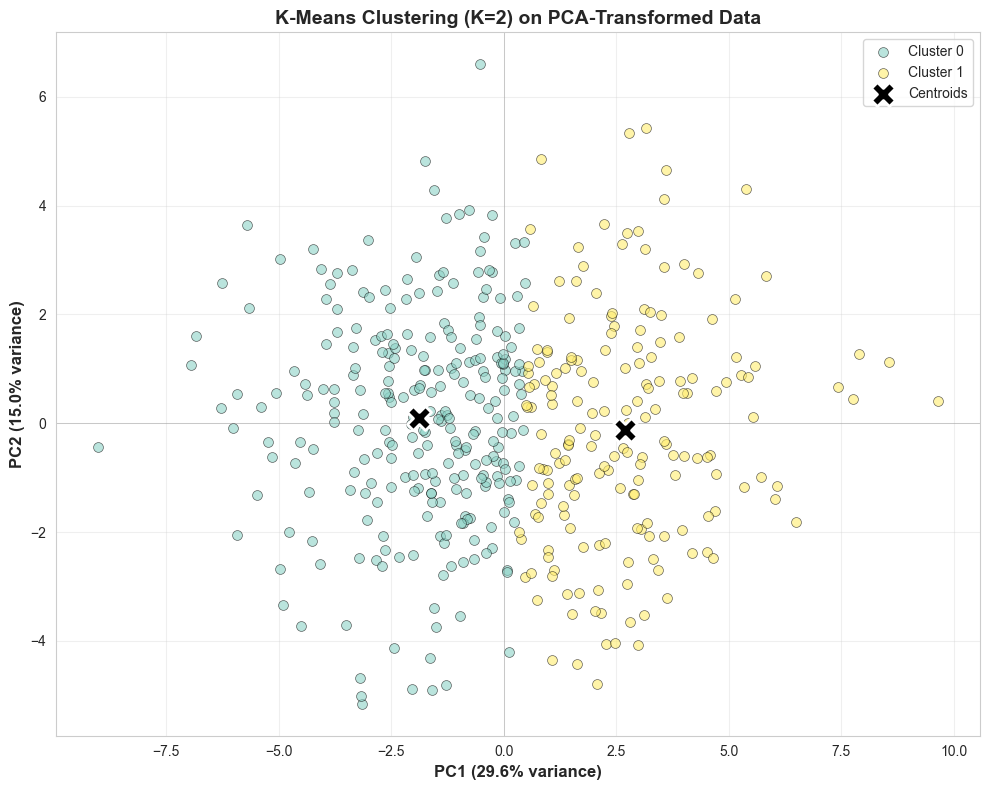

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.Set3(np.linspace(0, 1, best_k))
for cluster_id in range(best_k):
    mask = cluster_labels == cluster_id
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[colors[cluster_id]], label=f'Cluster {cluster_id}', 
               s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

centers_pca = kmeans_best.cluster_centers_[:, :2]
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           marker='X', s=300, c='black', edgecolors='white', linewidth=2, 
           label='Centroids', zorder=10)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontweight='bold', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontweight='bold', fontsize=12)
ax.set_title(f'K-Means Clustering (K={best_k}) on PCA-Transformed Data', fontweight='bold', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "06_kmeans_clusters_pca.png", dpi=300, bbox_inches='tight')
plt.show()

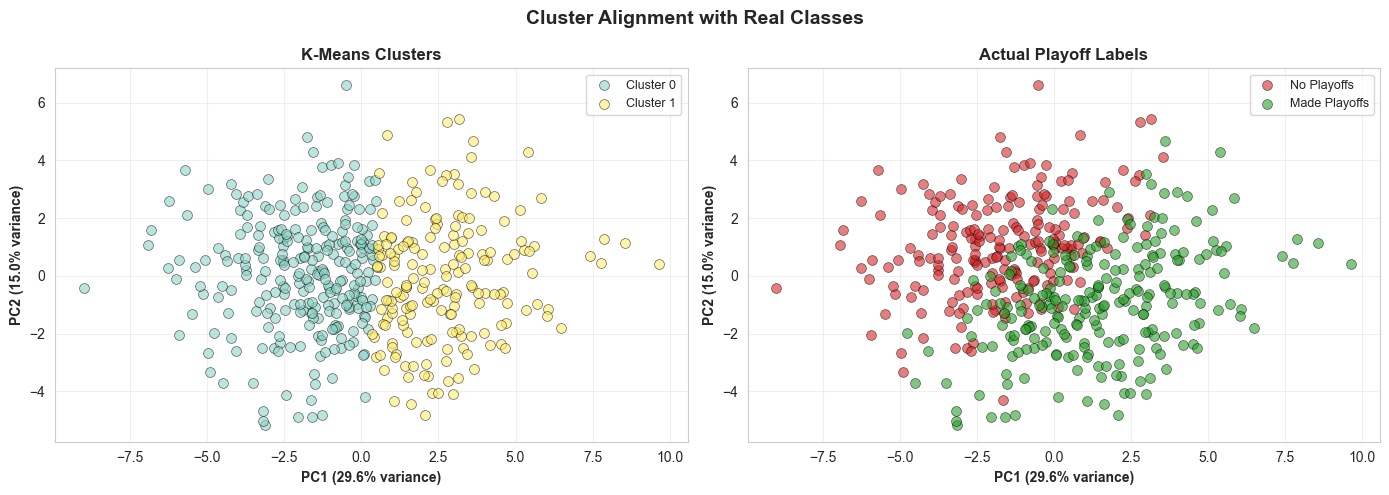

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
for cluster_id in range(best_k):
    mask = cluster_labels == cluster_id
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[colors[cluster_id]], label=f'Cluster {cluster_id}', 
               s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontweight='bold')
ax.set_title('K-Means Clusters', fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)

ax = axes[1]
no_playoff_mask = y_train == 0
playoff_mask = y_train == 1

ax.scatter(X_pca[no_playoff_mask, 0], X_pca[no_playoff_mask, 1], 
           c='#d62728', label='No Playoffs', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
ax.scatter(X_pca[playoff_mask, 0], X_pca[playoff_mask, 1], 
           c='#2ca02c', label='Made Playoffs', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontweight='bold')
ax.set_title('Actual Playoff Labels', fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)

plt.suptitle('Cluster Alignment with Real Classes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "07_cluster_vs_labels.png", dpi=300, bbox_inches='tight')
plt.show()

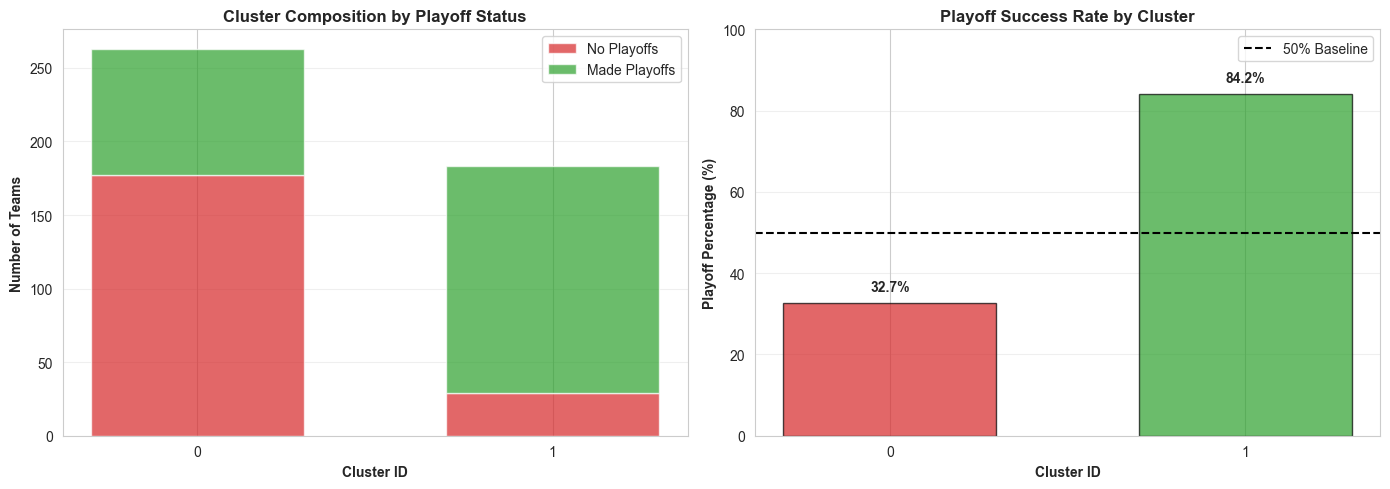

Cluster Statistics:
  Cluster 0: 263 teams total
    - 86 made playoffs (32.7%)
    - 177 did not make playoffs (67.3%)
  Cluster 1: 183 teams total
    - 154 made playoffs (84.2%)
    - 29 did not make playoffs (15.8%)


In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
cluster_playoff_counts = []
for cluster_id in range(best_k):
    mask = cluster_labels == cluster_id
    playoff_count = np.sum(y_train[mask])
    no_playoff_count = np.sum(mask) - playoff_count
    cluster_playoff_counts.append([no_playoff_count, playoff_count])

cluster_playoff_counts = np.array(cluster_playoff_counts)
x = np.arange(best_k)
width = 0.6

ax.bar(x, cluster_playoff_counts[:, 0], width, label='No Playoffs', color='#d62728', alpha=0.7)
ax.bar(x, cluster_playoff_counts[:, 1], width, bottom=cluster_playoff_counts[:, 0], 
       label='Made Playoffs', color='#2ca02c', alpha=0.7)

ax.set_xlabel('Cluster ID', fontweight='bold')
ax.set_ylabel('Number of Teams', fontweight='bold')
ax.set_title('Cluster Composition by Playoff Status', fontweight='bold')
ax.set_xticks(x)
ax.legend()
ax.grid(alpha=0.3, axis='y')

ax = axes[1]
playoff_percentages = cluster_playoff_counts[:, 1] / cluster_playoff_counts.sum(axis=1) * 100
bar_colors = ['#d62728' if pct < 50 else '#2ca02c' for pct in playoff_percentages]

ax.bar(x, playoff_percentages, width, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1)
ax.axhline(y=50, color='black', linestyle='--', linewidth=1.5, label='50% Baseline')
ax.set_xlabel('Cluster ID', fontweight='bold')
ax.set_ylabel('Playoff Percentage (%)', fontweight='bold')
ax.set_title('Playoff Success Rate by Cluster', fontweight='bold')
ax.set_xticks(x)
ax.set_ylim([0, 100])
ax.legend()
ax.grid(alpha=0.3, axis='y')

for i, pct in enumerate(playoff_percentages):
    ax.text(i, pct + 3, f'{pct:.1f}%', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "08_cluster_playoff_relationship.png", dpi=300, bbox_inches='tight')
plt.show()

print("Cluster Statistics:")
for cluster_id in range(best_k):
    mask = cluster_labels == cluster_id
    total = np.sum(mask)
    playoff_count = np.sum(y_train[mask])
    no_playoff_count = total - playoff_count
    playoff_pct = playoff_count / total * 100 if total > 0 else 0
    print(f"  Cluster {cluster_id}: {total} teams total")
    print(f"    - {playoff_count} made playoffs ({playoff_pct:.1f}%)")
    print(f"    - {no_playoff_count} did not make playoffs ({100-playoff_pct:.1f}%)")